## EDA 
**In this notebook we do an early look into the data and try to figure out what's going on.**


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import os

from random import randint, sample

## Loading the data

In [2]:
train_meta = pd.read_parquet("/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet")
test_meta = pd.read_parquet("/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet")
baseline_submission = pd.read_parquet("/kaggle/input/icecube-neutrinos-in-deep-ice/sample_submission.parquet")
sensor_geometry = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')

We have the following datasets:

* `train_meta` - train data that has batch_id, first_pulse_index, last_pulse_index and azimuth and zenith of a neutrino
* `test_meta` - test dats that has batch_id, first_pulse_index, last_pulse_index and we need to predict azimuth and zenith
* `submissions` - has to have event_id and predicted azimuth and zenith
* `sensor_geometry` - we have 5160 sensors and this dataset has their coordinates x,y,z within the IceCube
* `batch_xxx` - 660 data sets of train data:
    * *sensor_id* that picked the signal up
    * *time* time in absolute units, relative to current event_id only, doesn't have any relevance to the time on the Earth
    * *charge* an estimate of the amount of light in the pulse, in units of photoelectrons (p.e.)
    * *auxiliary* If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If False, then this pulse was contributed to the trigger decision and the pulse was fully digitized.
* `batch_661` - test data set


**We have the following immidiate observations**:
* The datasets are very large, about 120GB in compressed format. 
* Train data has 132 million event entries, test data has only 3 entries. We expect to see roughly one million events in the hidden test set, split between multiple batches.
* The neutrino signal could be attributed to both auxiliary ('faulty') and fully digitalized sensors

**What is an event?**

* An event is detection of a neutrino by IceCube sensors, thus it includes a series of sequential sensor reads of the neutrino (some of these reads are not fully digitalized (i.e. faulty))
* In the data we have start of event sample, end of event and zenith and azimuth.

**What is zenith and azimuth?**

* Basically it is angles that describe the direction of the movement.
* That's what we are after - we need to predict the direction of the neutrino's movement

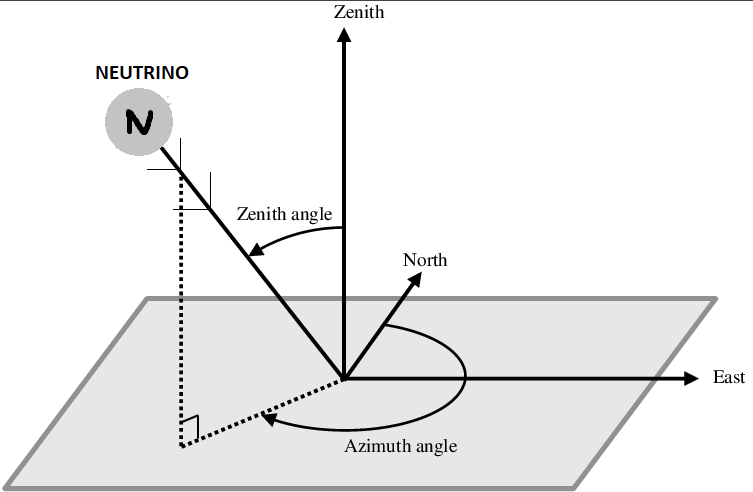

## A closer look at `train_meta`

* We will take a sample of 10,000,000 events

In [3]:
train_sample = train_meta.sample(n=10000000, random_state=0)

In [4]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 14636574 to 39947820
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   batch_id           int64  
 1   event_id           Int64  
 2   first_pulse_index  int64  
 3   last_pulse_index   int64  
 4   azimuth            float64
 5   zenith             float64
dtypes: Int64(1), float64(2), int64(3)
memory usage: 543.6 MB


**Pulse duration distribution**

 * It looks like poisson's distribution with a lot of values concentrated at zero
 

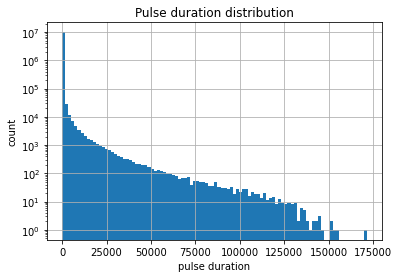

In [5]:
plt.hist(train_sample["last_pulse_index"]-train_sample["first_pulse_index"], bins=100, log=True)
plt.ylabel('count'), plt.xlabel('pulse duration')
plt.title('Pulse duration distribution')
plt.grid()

 **Azimuth and Zenith distribution**
 
 * Azimuth distribution looks like multi-peak distribution, should be probably closer to uniform and it could be a sampling issue
 * Zenith distribution has a clear peak at 90 degrees which makes sense, probably the most and better detected neutrinos come from 'above' and the senosors have better time detecting those (also if it comes at almost 180 degree angle - it is more difficult to detect)

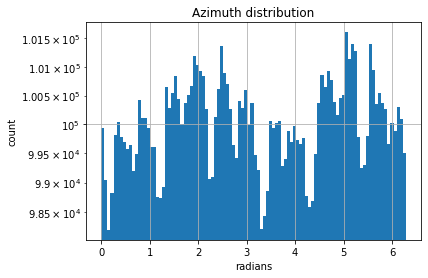

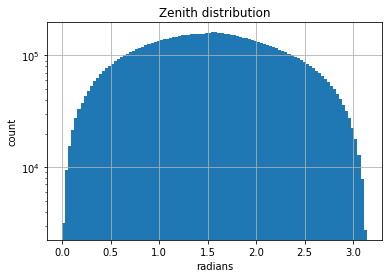

In [6]:
plt.hist(train_sample['azimuth'], bins=100, log=True)
plt.ylabel('count'), plt.xlabel('radians')
plt.title('Azimuth distribution')
plt.grid()
plt.show()

plt.hist(train_sample['zenith'], bins=100, log=True)
plt.ylabel('count'), plt.xlabel('radians')
plt.title('Zenith distribution')
plt.grid()
plt.show()

## Looking closer at an event

* Picking a random batch to look at / play with

In [7]:
batch_394 = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_394.parquet')

In [8]:
batch_394.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33342020 entries, 1279290174 to 1282536818
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   sensor_id  int16  
 1   time       int64  
 2   charge     float64
 3   auxiliary  bool   
dtypes: bool(1), float64(1), int16(1), int64(1)
memory usage: 858.5 MB


In [9]:
batch_394.head(20)

,sensor_id,time,charge,auxiliary
event_id,,,,
1279290174,1905,6203,1.175,True
1279290174,3842,6666,0.775,True
1279290174,3873,7391,0.775,True
1279290174,1137,7868,1.025,True
1279290174,4565,8391,0.575,True
1279290174,2029,8588,0.975,True
1279290174,4253,8613,1.175,True
1279290174,4560,9019,0.875,True
1279290174,4152,9294,1.125,True


* We see in the event 1279290174, it started with faulty signals and then at sensor 3620 picked up a fully digitalized one

In [10]:
event_id_sample = 1279290174
train_meta.loc[train_meta['event_id'] == event_id_sample]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
78600000,394,1279290174,0,44,0.301062,0.653049


**Plotting an event**

**Auxiliary ON**

In [11]:
event_id_sample = 1279290174
event_data = batch_394[batch_394.index == event_id_sample].sort_values("time")

fig = px.scatter_3d()
fig.update_traces(marker_size=3)

event_meta = train_meta[train_meta["event_id"] == event_id_sample]
azimuth, zenith = event_meta["azimuth"].values[0], event_meta["zenith"].values[0]
true_x = np.cos(azimuth) * np.sin(zenith)
true_y = np.sin(azimuth) * np.sin(zenith)
true_z = np.cos(zenith)

for idx, row in event_data.iterrows():
    curr_sensor_data = sensor_geometry[sensor_geometry["sensor_id"] == row["sensor_id"]]
    curr_x, curr_y, curr_z = curr_sensor_data["x"].values[0], curr_sensor_data["y"].values[0], curr_sensor_data["z"].values[0]
    fig.add_trace(
        go.Scatter3d(x=[curr_x], y=[curr_y], z=[curr_z], mode='markers', text=f'charge: {row["charge"]}', marker=dict(size=row["charge"]*5, color=row['time']))
    )

fig.add_trace(
            go.Scatter3d(
                x=[-true_x * 500, true_x * 500], y=[-true_y * 500, true_y * 500], z=[-true_z * 500, true_z * 500],
                opacity=0.8, mode='lines', line=dict(color='red', width=5)
            ))
fig.show()

In [12]:
event_id_sample = 1279290174
event_data = batch_394.loc[(batch_394.index == event_id_sample) & (batch_394.auxiliary == False)].sort_values("time")

#fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', opacity=0.75, color_discrete_sequence=['gray'])
#fig.update_traces(marker_size=3)

fig = px.scatter_3d()
event_meta = train_meta[train_meta["event_id"] == event_id_sample]
azimuth, zenith = event_meta["azimuth"].values[0], event_meta["zenith"].values[0]
true_x = np.cos(azimuth) * np.sin(zenith)
true_y = np.sin(azimuth) * np.sin(zenith)
true_z = np.cos(zenith)

for idx, row in event_data.iterrows():
    curr_sensor_data = sensor_geometry[sensor_geometry["sensor_id"] == row["sensor_id"]]
    curr_x, curr_y, curr_z = curr_sensor_data["x"].values[0], curr_sensor_data["y"].values[0], curr_sensor_data["z"].values[0]
    fig.add_trace(
        go.Scatter3d(x=[curr_x], y=[curr_y], z=[curr_z], mode='markers', text=f'charge: {row["charge"]}', marker=dict(size=row["charge"]*5, color=row['time']))
    )

fig.add_trace(
            go.Scatter3d(
                x=[-true_x * 500, true_x * 500], y=[-true_y * 500, true_y * 500], z=[-true_z * 500, true_z * 500],
                opacity=0.8, mode='lines', line=dict(color='red', width=5)
            ))
fig.show()

In [13]:
batch_394.iloc[5198375]

sensor_id     4591
time         98239
charge       1.125
auxiliary     True
Name: 1279793959, dtype: object

In [14]:
event_id_sample = 1279793959
event_data = batch_394.loc[(batch_394.index == event_id_sample) & (batch_394.auxiliary == False)].sort_values("time")

#fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', opacity=0.75, color_discrete_sequence=['gray'])
#fig.update_traces(marker_size=3)

fig = px.scatter_3d()
event_meta = train_meta[train_meta["event_id"] == event_id_sample]
azimuth, zenith = event_meta["azimuth"].values[0], event_meta["zenith"].values[0]
true_x = np.cos(azimuth) * np.sin(zenith)
true_y = np.sin(azimuth) * np.sin(zenith)
true_z = np.cos(zenith)

for idx, row in event_data.iterrows():
    curr_sensor_data = sensor_geometry[sensor_geometry["sensor_id"] == row["sensor_id"]]
    curr_x, curr_y, curr_z = curr_sensor_data["x"].values[0], curr_sensor_data["y"].values[0], curr_sensor_data["z"].values[0]
    fig.add_trace(
        go.Scatter3d(x=[curr_x], y=[curr_y], z=[curr_z], mode='markers', text=f'charge: {row["charge"]}', marker=dict(size=row["charge"]*5, color=row['time']))
    )

fig.add_trace(
            go.Scatter3d(
                x=[-true_x * 500, true_x * 500], y=[-true_y * 500, true_y * 500], z=[-true_z * 500, true_z * 500],
                opacity=0.8, mode='lines', line=dict(color='red', width=5)
            ))
fig.show()

* It is a bit difficult to make sense of the cubes and the lines above, however, from the competition description picture - it is kinda clear that the line goes through the sensors when auxiliary == False

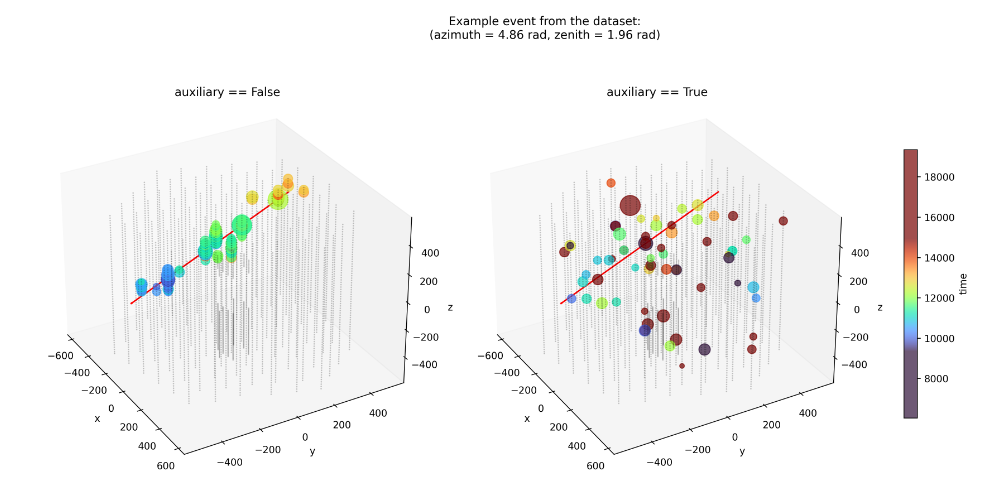

* This picture motivates a few simple ideas to test:

1. If we know coordinates of sensors that neutrino went through - 2 coordinates should be enough to determine both azimuth and zenith
2. We have a sample of dots (sensors) that detected neutrinos - we can make a simple regression to draw a line through these dots

## Can we predict neutrino direction just by connecting two dots?

* The question is what dots to choose? 